In [56]:
#  Import relevant libraries

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [57]:
#  Retreive the data from SQL 

# Define your database connection parameters
db_username = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5432'
db_name = 'Group 4 Project Statistics'
db_table = 'refined_data_1'

# Create the connection string
connection_string = f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Query the data from your table
query = f'SELECT * FROM {db_table}'

# Read the data into a pandas DataFrame
data = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Display the DataFrame
display(data.head())
print("Original data types:")
print(data.dtypes)

,season_end,team,average_distance_to_away_games,squad_value,net_summer_transfer_spend,retained_manager,average_attendance,wage_bill,retained_captain,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,position_bin,games_played,number_of_managers_employed_in_the_season
0,2019,Arsenal,371,580750000,71050000,False,59989,135360000,False,67,0,23,6,2,58,1
1,2020,Arsenal,163,604250000,107150000,True,60279,118540000,False,79,-3,22,5,1,54,2
2,2021,Arsenal,173,540800000,57140000,True,10000,147450000,True,108,5,8,8,1,54,1
3,2022,Arsenal,162,521000000,116250000,True,59763,114370000,False,68,4,16,8,2,45,1
4,2023,Arsenal,153,935000000,144080000,True,60186,101660000,False,72,1,13,5,2,54,1


Original data types:
season_end                                   object
team                                         object
average_distance_to_away_games                int64
squad_value                                   int64
net_summer_transfer_spend                     int64
retained_manager                               bool
average_attendance                            int64
wage_bill                                     int64
retained_captain                               bool
previous_season_disciplinary_points           int64
net_number_of_transfers                       int64
previous_season_goal_difference               int64
previous_season_position                      int64
position_bin                                  int64
games_played                                  int64
number_of_managers_employed_in_the_season     int64
dtype: object


In [58]:
# Drop any irrelevant data

# Drop the Season End column
data = data.drop('season_end', axis=1)

# Drop the Team column
data = data.drop('team', axis=1)

# Drop the Average Distance to Away Games column

data = data.drop('average_distance_to_away_games', axis=1)

# Display the first few rows to verify it's loaded correctly

display(data.head())

print("Original data types:")

print(data.dtypes)

,squad_value,net_summer_transfer_spend,retained_manager,average_attendance,wage_bill,retained_captain,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,position_bin,games_played,number_of_managers_employed_in_the_season
0,580750000,71050000,False,59989,135360000,False,67,0,23,6,2,58,1
1,604250000,107150000,True,60279,118540000,False,79,-3,22,5,1,54,2
2,540800000,57140000,True,10000,147450000,True,108,5,8,8,1,54,1
3,521000000,116250000,True,59763,114370000,False,68,4,16,8,2,45,1
4,935000000,144080000,True,60186,101660000,False,72,1,13,5,2,54,1


Original data types:
squad_value                                  int64
net_summer_transfer_spend                    int64
retained_manager                              bool
average_attendance                           int64
wage_bill                                    int64
retained_captain                              bool
previous_season_disciplinary_points          int64
net_number_of_transfers                      int64
previous_season_goal_difference              int64
previous_season_position                     int64
position_bin                                 int64
games_played                                 int64
number_of_managers_employed_in_the_season    int64
dtype: object


In [59]:
#  Preprocessing

# Function to identify problematic columns
def identify_mixed_type_columns(df):
    mixed_type_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                pd.to_numeric(df[column])
            except ValueError:
                if df[column].str.contains(',').any():  # Check if any cell contains a comma
                    mixed_type_columns.append(column)
    return mixed_type_columns

# Identify problematic columns
problematic_columns = identify_mixed_type_columns(data)
print("Problematic columns:", problematic_columns)

# Handle problematic columns
for column in problematic_columns:
    data[column] = data[column].str.replace(',', '')  # Remove commas
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN

# Identify numeric and categorical columns
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# After identifying numeric and categorical features
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Check if there are any categorical features
if len(categorical_features) == 0:
    print("No categorical features found. Adjusting preprocessor.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

# Remove 'Position Bin' from features if it's present
if 'position_bin' in numeric_features:
    numeric_features.remove('position_bin')
if 'position_bin' in categorical_features:
    categorical_features.remove('position_bin')

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Problematic columns: []
Numeric features: ['squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position', 'position_bin', 'games_played', 'number_of_managers_employed_in_the_season']
Categorical features: []
No categorical features found. Adjusting preprocessor.


In [60]:
# Prepare the features and target

X = data.drop('position_bin', axis=1)
y = data['position_bin']

In [61]:
# Encode target variable

le = LabelEncoder()
y = le.fit_transform(y)

In [62]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Fit the preprocessor on the training data and transform both training and test data

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [64]:
# Get feature names after preprocessing

feature_names = numeric_features.copy()
if len(categorical_features) > 0:
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()
    feature_names += cat_feature_names


In [65]:
# Convert to DataFrames

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [66]:
print("Preprocessing complete. Ready for model training.")
print(f"Training set shape: {X_train_preprocessed.shape}")
print(f"Testing set shape: {X_test_preprocessed.shape}")

Preprocessing complete. Ready for model training.
Training set shape: (288, 10)
Testing set shape: (72, 10)


In [67]:
# Display sample of preprocessed features to verify

display("\nSample of preprocessed features (training set):")
display(X_train.head())

'\nSample of preprocessed features (training set):'

,squad_value,net_summer_transfer_spend,retained_manager,average_attendance,wage_bill,retained_captain,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,games_played,number_of_managers_employed_in_the_season
289,496500000,4760000,True,8000,77526000,True,54,-2,26,5,53,1
336,416400000,123970000,False,30464,49556000,True,70,3,-24,15,40,3
231,349450000,60060000,True,59151,74556000,True,57,-1,15,6,56,1
75,659680000,155620000,True,72726,165440000,False,87,2,11,6,61,1
194,801100000,52150000,True,74498,151325000,False,69,1,40,2,53,2


In [68]:
# Print feature names after preprocessing

print("\nFeature names after preprocessing:")
print(X_train_preprocessed.columns.tolist())


Feature names after preprocessing:
['squad_value', 'net_summer_transfer_spend', 'average_attendance', 'wage_bill', 'previous_season_disciplinary_points', 'net_number_of_transfers', 'previous_season_goal_difference', 'previous_season_position', 'games_played', 'number_of_managers_employed_in_the_season']


In [69]:
# Train a RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:
# Make predictions

y_pred = rf.predict(X_test)

In [71]:
# Evaluate the model

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.91      0.91      0.91        32
           2       1.00      1.00      1.00        26

    accuracy                           0.92        72
   macro avg       0.90      0.90      0.90        72
weighted avg       0.92      0.92      0.92        72


Confusion Matrix:
[[11  3  0]
 [ 3 29  0]
 [ 0  0 26]]


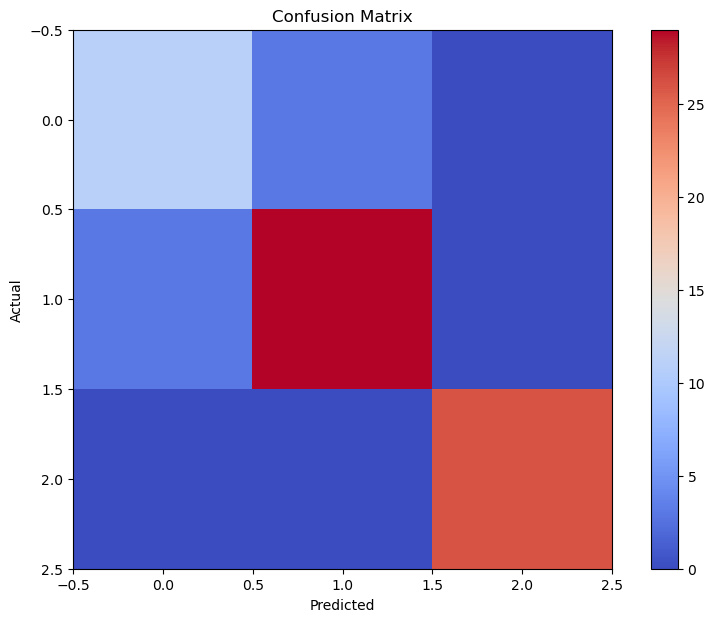

In [72]:
# Visualize the confusion matrix

plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Top 10 Most Important Features:
   Importance                                    Feature
0    0.162959                                squad_value
1    0.152660        previous_season_disciplinary_points
2    0.097078  number_of_managers_employed_in_the_season
3    0.092184                               games_played
4    0.076685                                  wage_bill
5    0.071436            previous_season_goal_difference
6    0.061151                  net_summer_transfer_spend
7    0.043897                   previous_season_position
8    0.012708                    net_number_of_transfers
9    0.012250                         average_attendance


<Figure size 1000x600 with 0 Axes>

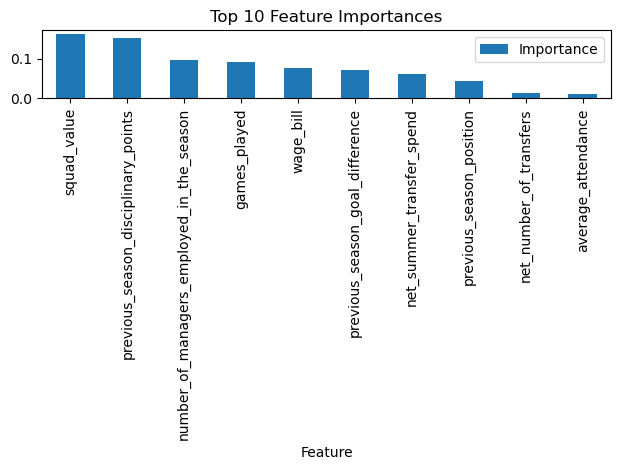

In [73]:
# Get feature importances

importances = rf.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X_train_preprocessed.columns), reverse=True), 
                           columns=['Importance', 'Feature'])

# Display top 10 most important features

print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))

# Visualize feature importances

plt.figure(figsize=(10, 6))
feature_imp.head(10).plot(x='Feature', y='Importance', kind='bar')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [74]:
X_test.head()

,squad_value,net_summer_transfer_spend,retained_manager,average_attendance,wage_bill,retained_captain,previous_season_disciplinary_points,net_number_of_transfers,previous_season_goal_difference,previous_season_position,games_played,number_of_managers_employed_in_the_season
224,239300000,-21740000,True,20015,49398000,True,80,3,-20,14,41,1
42,441750000,71150000,True,39042,85707000,True,60,0,-14,8,41,1
285,181000000,2050000,True,4259,88735000,True,71,2,-19,14,38,1
302,236900000,30510000,True,16899,21130000,False,59,3,-37,20,42,1
56,437530000,18800000,False,31832,79900000,True,65,2,-4,9,45,2


In [75]:
#save model for use in flask

import joblib

joblib.dump(rf, '../app/model.joblib')

['../app/model.joblib']